In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
import numpy as np

abtem.config.set({"local_diagnostics.progress_bar": False});

(walkthrough:wave_functions)= 
# Wave functions
The multislice algorithm works by propagating the $xy$ part of the wave function (defined as $\psi$ in the [appendix](../appendix/multislice_derivation.ipynb)) through the electrostatic potential. To start the propagation, we need to assume the initial conditions for the wave function, i.e. a wave function describing the electron beam formed by the electron optics before the sample.

*ab*TEM defines three types of wave functions:

* [`PlaneWave`](wave_functions:plane_wave): Simulate HRTEM, SAED or other imaging modes with parallel-beam plane wave illumination.
* [`Probe`](wave_functions:probe): Simulate CBED, STEM or other imaging modes with a converged electron beam.
* `Waves`: Defines any custom wave function. `PlaneWave` and `Probe` can be converted to `Waves`.

```{seealso}
The PRISM algorithm uses `SMatrix`, which is not included in the list above. However, in most ways it can be used similar to `Probe`; see our [tutorial on PRISM in abTEM](tutorials:prism) for more detail.
```

(wave_functions:plane_wave)=
## Plane wave functions

The default plane wave is just defined to be equal to unity everywhere in the plane

$$
    \psi(\vec{r}) = 1 \quad ,
$$

where $\vec{r} = (x, y)$ is the real space coordinate in the $x$- and $y$-direction. While mathematically, those coordinates are usually considered to be continuous, in a numerical simulation we have define a discrete grid with a finite extent to represent them.

We create a plane wave on a $256 \times 256$ grid with a lateral extent of $5\times 5$ $\mathrm{Å}^2$ and an energy of $300 \ \mathrm{keV}$.

In [2]:
plane_wave = abtem.PlaneWave(gpts=256, extent=5, energy=300e3)

The real-space sampling, or pixel size, is calculated by dividing the `extent` by the number of grid points (`gpts`). The properties related to the grid, i.e. the `extent`, `gpts` and `sampling`, can be accessed as properties of the `PlaneWave` object.

In [3]:
plane_wave.extent, plane_wave.gpts, plane_wave.sampling

((5.0, 5.0), (256, 256), (0.01953125, 0.01953125))

The grid is fully defined from just two of the three quantities listed above, and thus we may pick any combination of two to define it. 

The relativistic wavelength in Ångstrom, derived from the energy, is accessed as:

In [4]:
print(f"Wavelength: {plane_wave.wavelength:.4f} Å")

Wavelength: 0.0197 Å


```{note}
abTEM uses the same unit conventions as ASE, as defined in the `ase.units` module. Thus, electron volts (eV), Ångström (Å), and atomic mass units are defined as 1.0. The electrostatic potential is given in (eV / e). Angles in *ab*TEM are for convenience given in milliradians (mrad).

```
We can turn the `PlaneWave` into a generic `Waves` by using `build`.

In [5]:
waves = plane_wave.build()
waves

The `Waves` describe the wave function as a complex Dask array (see our page on [parallelization](parallelization.ipynb)), as accessed below.

In [6]:
waves.array

dask.array<_extract_measurement, shape=(256, 256), dtype=complex64, chunksize=(256, 256), chunktype=numpy.ndarray>

After actually computing the values of the wave function, it will be described as a NumPy array.

In [7]:
waves.compute()

waves.array

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
      dtype=complex64)

The normalization of the wave function used above ensures that the intensity per area is constant when the grid is changed. However, this is not a very natural normalization in Fourier space, and we may instead define the plane wave such that the direct beam is $1$ before scattering.

$$
    \hat{\psi}(\vec{k}) = \delta(0) \quad .
$$

We create a plane wave with this normalization by setting `normalize=True`.

In [8]:
normalized_plane_wave = abtem.PlaneWave(
    gpts=256, extent=5, energy=300e3, normalize=True
)

(wave_functions:probe)=
## Probe wave functions

In *ab*TEM, a focused beam of electrons, or `Probe`, is defined in Fourier space as

$$
    \hat{\psi}(\vec{k}) = A(\vec{k}) \ \exp(-i \chi(\vec{k})) \quad ,
$$

where $A(k)$ is the aperture function, $\chi(\vec{k})$ is the phase error and $\vec{k} = (k_x, k_y)$ is the spatial frequency in $x$ and $y$, respectively. The real-space probe is just the inverse Fourier transform

$$
    \psi(\vec{r}) = \mathcal{F}^{-1} \left[ \hat{\psi}(\vec{r}) \right] \quad .
$$

The probe wave function is normalized such that its intensity sums to $1$ in Fourier space

$$
    \int \|\hat{\psi}\|^2 d\vec{k} = 1 \quad .
$$

We create a probe with a `sampling` of $0.05 \ \mathrm{Å}$, an `extent` of $20\times 20$ $\mathrm{Å}^2$, an `energy` of $80 \ \mathrm{keV}$, a convergence semiangle (`semiangle_cutoff`) of $30 \ \mathrm{mrad}$, a defocus (`C10`; note the common negative sign convention here) of $-50 \ \mathrm{Å}$ and spherical aberration (`Cs`) of $-50 \ \mathrm{\mu m}$ (note the conversion to $\mathrm{m}$ and then to $\mathrm{Å}$).

In [9]:
probe = abtem.Probe(
    sampling=0.05,
    extent=20,
    energy=80e3,
    semiangle_cutoff=20,
    C10=50,
    Cs=-50e-6 * 1e10,
)

```{seealso}
See our [introduction to the contrast transfer function](walkthrough:contrast_transfer_function) for a full list of phase aberrations.
```

We can again turn the `Probe` into the generic `Waves` by using `build`, which, as the plane wave, is represented by a Dask array.

In [10]:
waves = probe.build()

waves.array

dask.array<getitem, shape=(400, 400), dtype=complex64, chunksize=(400, 400), chunktype=numpy.ndarray>

## Visualizing the wave function 

To visualize the wave function using *ab*TEM's built-in visualization module, we first have to convert it to a measurement type. The most common methods are `intensity` and `diffraction_patterns`, which will return a measurement of type `Images` and `DiffractionPatterns`, respectively.

The real space intensity, $\|\psi\|^2$, is calculated and shown below. The parameter `cbar=True` displays the color intensity scale.

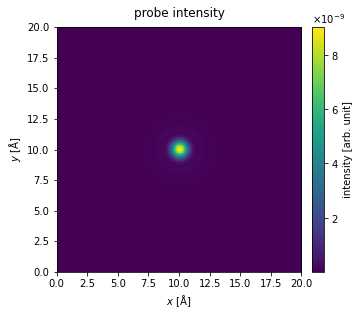

In [11]:
intensity = probe.build().intensity().compute()

visualization = intensity.show(cbar=True)
visualization.set_column_titles("probe intensity", fontsize=12)

````{note}
The axes convention for arrays representing a wave functions assigns the first axis to the $x$-axis and the second axis to the $y$-axis, and a larger array index implies a larger real-space coordinate. This is different from the convention often used for images. The correct way of displaying an array with `matplotplib` is given below.
    
```python
import matplotlib.pyplot as plt
image = waves.intensity().array
plt.imshow(image.T, extent=[0, waves.extent[0], 0, waves.extent[1]], origin='lower')
```     
````

Showing a lineprofile sometimes provides a more understable visualization. We use `interpolate_line_at_position` to create a `LineProfile` across the center of the probe intensity.

In [12]:
lineprofile = intensity.interpolate_line_at_position(
    center=(10, 10), angle=0, extent=10
)

In [13]:
lineprofile.shape

(200,)

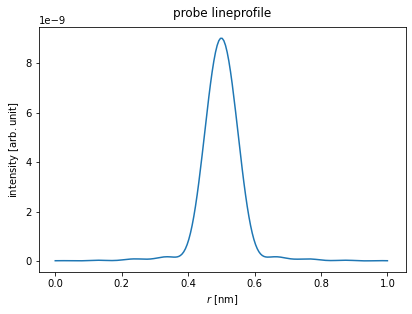

In [14]:
from abtem.visualize import AxesGrid, MeasurementVisualization1D

fig = plt.figure(figsize=(6, 4))

axes = AxesGrid(fig, 1, 1, 0, aspect=False)
# axes.set_aspect(.8)

viz = MeasurementVisualization1D(lineprofile, axes, ())

viz.set_x_units("nm")
viz.set_column_titles("probe lineprofile", fontsize=12)

It is often useful to know the width of the probe. Below we calculate the width at $0.5$ of the height of the probe (i.e. the full width at half-maximum, FWHM).

In [15]:
fwhm = lineprofile.width(height=0.5)

print(f"FWHM = {fwhm.item():.2f} Å")

FWHM = 1.11 Å


The Fourier-space intensity, $\|\hat{\psi}\|^2$, is calculated and shown below. We set `max_angle=60` to only include angles up to $60 \ \mathrm{mrad}$.

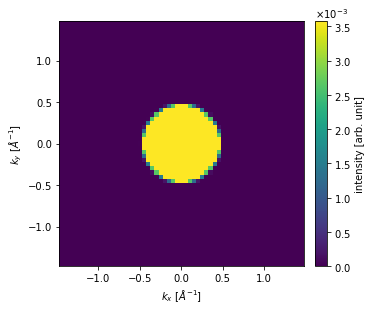

In [16]:
diffraction_patterns = probe.build().diffraction_patterns(max_angle=60)

diffraction_patterns.show(cbar=True);

Alternative to reciprocal-space units, we can display diffraction patterns in angular units by using the keyword `units='mrad'`.

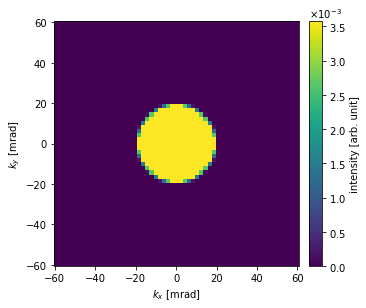

In [17]:
diffraction_patterns.show(cbar=True, units="mrad");

## Wave-function ensembles

In general, `Waves` can represent an ensemble of wave functions as a multidimensional array.  The last two dimensions of `Waves` represent the spatial dimensions, which are the mandatory or *base* dimensions of the object. Any preceeding dimension is an optional *ensemble* dimension. The ensemble dimensions may represent a range of defocii, positions, frozen phonons, tilt and more. In computations, *ab*TEM will automatically parallelize over the ensemble dimensions.

As an example, we create an ensemble of probes with different values for their defocus. 

In [18]:
defocus_series = np.linspace(0, 200, 5)

probe_focal_series = abtem.Probe(
    gpts=256,
    extent=25,
    energy=80e3,
    semiangle_cutoff=20,
    defocus=defocus_series,
)

waves_focal_series = probe_focal_series.build().compute()

```{warning}
Not every parameter in *ab*TEM allows this.
```

Now `Waves` is a 1D ensemble of 2D wave functions, hence its shape is 3D.

In [19]:
waves_focal_series.shape

(5, 256, 256)

We can inspect the `axes_metadata` property to see that the first axis is the ensemble `ParameterAxis` over `C10`, equivalent to negative defocus, and the base are `RealSpaceAxis`. 

In [20]:
waves_focal_series.axes_metadata

type           label    coordinates
-------------  -------  ------------------------
ParameterAxis  C10 [Å]  -0.00 -50.00 ... -200.00
RealSpaceAxis  x [Å]    0.00 0.10 ... 24.90
RealSpaceAxis  y [Å]    0.00 0.10 ... 24.90

When calculating the intensity we obtain an ensemble of `Images`, which can be conveniently shown in an "exploded" plot. 

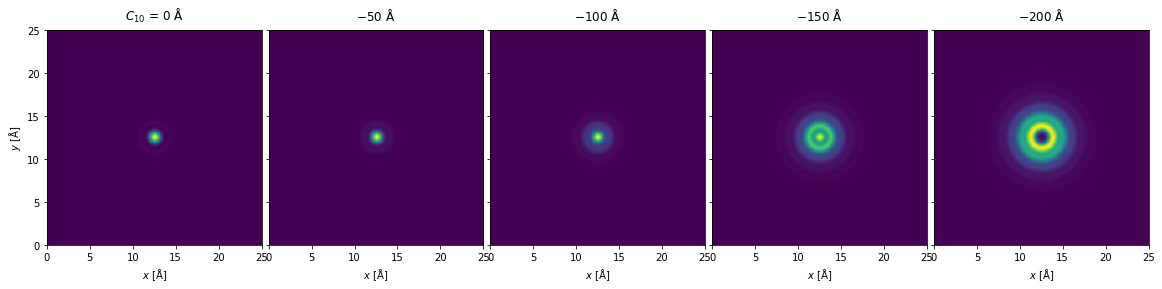

In [21]:
visualization = waves_focal_series.intensity().show(
    explode=True, figsize=(18, 4), cbar=False
);

````{seealso}
If you have [Hyperspy](https://hyperspy.org/) installed, you can view the ensemble interactively by converting the `Images` to a `hyperspy` signal and using the interactive viewer.
```python
waves_focal_series.interact()
```
*Note: This requires using a matplotlib backend that supports interactivity.*
````

When using methods, such as `interpolate_line_profiles`, on an ensemble, it will be applied to each member of the ensemble. The `show` method handles these automatically.

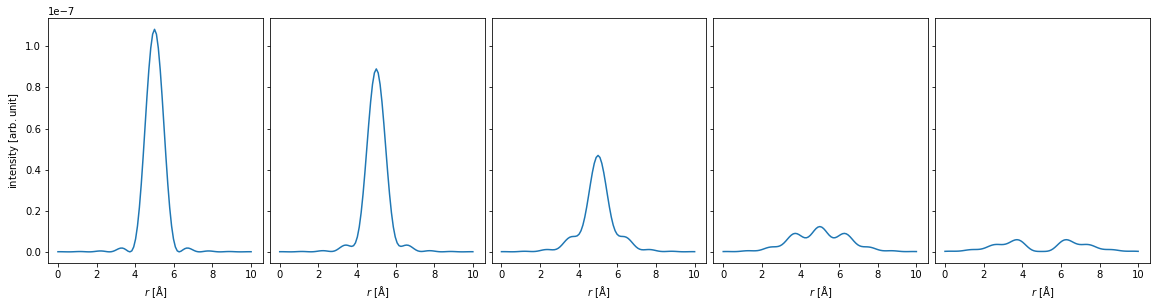

In [22]:
line_profiles = waves_focal_series.intensity().interpolate_line_at_position(
    center=(12.5, 12.5), angle=0, extent=10
)

visualization = line_profiles.show(
    explode=False, figsize=(18, 4), common_scale=True, axes_types=("explode",)
);

`Waves` can have any number of ensemble dimensions, for example, we can add two additional axes representing a scan in the $x$- and $y$- direction, thus producing a 3D ensemble of 2D wave functions.

In [23]:
scan = abtem.GridScan()

waves_focal_series_scanned = probe_focal_series.build(scan=scan)

waves_focal_series_scanned.shape

(5, 49, 49, 256, 256)

Be careful about running the `compute` method after adding ensemble dimensions without before applying a reduction operation, such as taking an ensemble mean or applying a detector. The below ensemble would take $\sim 4.51 \ \mathrm{GB}$ of memory to store, as the Dask array `__repr__` shows.

In [24]:
waves_focal_series_scanned.array

dask.array<_extract_measurement, shape=(5, 49, 49, 256, 256), dtype=complex64, chunksize=(5, 6, 7, 256, 256), chunktype=numpy.ndarray>